# Hotspot Calculations for HEP

Author: Brain Gravelle (gravelle@cs.uoregon.edu)


All this is using the taucmdr python libraries from paratools
http://taucommander.paratools.com/


## Imports

In [1]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
import numbers
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2e' % x)
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth', 70)

## Getting Data

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

From the talapas_scaling application the following experiments are available. These use Talapas (with 28 thread Broadwell processors) and the build-ce (realistic) option for mkFit
* manual_scaling_Large_talapas		
* manual_scaling_Large_talapas_fullnode	
* manual_scaling_TTbar70_talapas		
* manual_scaling_TTbar70_talapas_fullnode
* manual_scaling_TTbar35_talapas
* manual_scaling_TTbar35_talapas_fullnode


### Importing Scaling Data

In [2]:
# application = "talapas_scaling"
# experiment  = "manual_scaling_TTbar70_talapas"

application = "cori_scaling"
experiment  = "manual_scaling_TTbar35"

path = ".tau/" + application + "/" + experiment + "/"
# note that this function takes a long time to run, so only rerun if you must
metric_data = get_pandas_scaling(path)
# metric_data = remove_erroneous_threads(metric_data,  [1, 8, 16, 32, 48, 56])
metric_data = remove_erroneous_threads(metric_data,  [1, 8, 16, 32, 64, 128, 256])

Possible missing metric: 
nthread = 32 
metric = PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD


In [3]:
print(metric_data.keys())
print_available_metrics(metric_data,True)
select_metric_from_scaling(metric_data, 'PAPI_L2_TCA')

# level_inds = {'trial': 0, 'rank': 1, 'context': 2, 'thread': 3, 'region': 4}
print(metric_data[8]['PAPI_TOT_INS'].columns)
print("")
print(metric_data[8]['PAPI_TOT_INS'].index.names)
print("")
print_metadata(metric_data[8])

metric_data[8]['PAPI_TOT_INS'].sort_values(by='Inclusive',ascending=False)[["Inclusive"]].head(10)

[64, 32, 1, 8, 128, 256, 16]
PAPI_BR_INS
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD
PAPI_L2_TCA
PAPI_NATIVE_LLC_MISSES
PAPI_TLB_DM
PAPI_NATIVE_LLC_REFERENCES
PAPI_RES_STL
PAPI_L2_TCM
PAPI_TOT_INS
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD
PAPI_LST_INS
PAPI_BR_CN
PAPI_BR_UCN
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_TOT_CYC
Index([u'Calls', u'Exclusive', u'Inclusive', u'ProfileCalls', u'Subcalls'], dtype='object')

[u'context', u'thread', u'region']

TAU_MAX_THREADS                                    300
TAU_CUDA_BINARY_EXE                                None
TAU_MEASURE_TAU                                    off
Memory Size                                        98876884 kB
TAU_TRACK_SIGNALS                                  off
TAU_TRACK_IO_PARAMS                                off
CPU MHz                                            1401.000
Local Time                                         2018-04-15T17:59:21-07:00
CPU Type                                           Intel(R) Xeon Phi(TM) CPU 7250 @ 1.40GHz
TAU

Inclusive
context thread region                                                                           
0       1      [SUMMARY] syscall                                                        7.55e+08
        3      [SUMMARY] syscall                                                        7.34e+08
        0      [SUMMARY] Event::clean_cms_seedtracks()                                  7.17e+08
        4      [SUMMARY] syscall                                                        7.17e+08
        6      [SUMMARY] syscall                                                        6.97e+08
        2      [SUMMARY] syscall                                                        6.88e+08
        5      [SUMMARY] syscall                                                        6.70e+08
        7      [SUMMARY] syscall                                                        6.36e+08
        0      [SUMMARY] std::__detail::_Mod_range_hashing::operator()(unsigned lo...   5.85e+08
               [SUMMARY] __read_nocancel                                                4.72e+08

In [4]:
# Use this section to verify the scaling functions
# reads one exampple of the 8 thread PAPI_TOT_INS to show that the numbers are closeto above

# application = "test"
# experiment  = "test"

# path = ".tau/" + application + "/" + experiment + "/"
# t = get_pandas(path)


# # level_inds = {'trial': 0, 'rank': 1, 'context': 2, 'thread': 3, 'region': 4}
# print(t['PAPI_TOT_INS'].columns)
# print("")
# print(t['PAPI_TOT_INS'].index.names)
# print("")
# print_metadata(t)

# t['PAPI_TOT_INS'].sort_values(by='Inclusive',ascending=False)[["Inclusive"]].head(10)

## Adding metrics

metrics are available in metrics.py. At this time the following can be added:
* add_IPC(metrics)          - Instructions per Cycle
* add_CPI(metrics)          - Cycles per instruction
* add_VIPC(metrics)         - vector instructions per cycle
* add_VIPI(metrics)         - vector instructions per instruction (i.e. fraction of total)
* add_L1_missrate(metrics)  - miss rate for L1 cache

for scaling data please use the add_metric_to_scaling_data(data, metric_func) function to add a metric

In [5]:
add_metric_to_scaling_data(metric_data, add_CPI)
add_metric_to_scaling_data(metric_data, add_L1_missrate)
add_metric_to_scaling_data(metric_data, add_L2_missrate)
add_metric_to_scaling_data(metric_data, add_L3_missrate)
print_available_metrics(metric_data, scaling=True)

metric_data[1]['DERIVED_CPI'].head(10)

ERROR adding L3 MR to metric dictionary
ERROR adding L3 MR to metric dictionary
ERROR adding L3 MR to metric dictionary
ERROR adding L3 MR to metric dictionary
ERROR adding L3 MR to metric dictionary
ERROR adding L3 MR to metric dictionary
ERROR adding L3 MR to metric dictionary
ERROR adding metric to thread count: 64
ERROR adding metric to thread count: 32
ERROR adding metric to thread count: 1
ERROR adding metric to thread count: 8
ERROR adding metric to thread count: 128
ERROR adding metric to thread count: 256
ERROR adding metric to thread count: 16
PAPI_BR_INS
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD
PAPI_L2_TCA
PAPI_NATIVE_LLC_MISSES
PAPI_TLB_DM
PAPI_NATIVE_LLC_REFERENCES
DERIVED_L1_MISSRATE
PAPI_RES_STL
DERIVED_L2_MISSRATE
PAPI_L2_TCM
PAPI_TOT_INS
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD
DERIVED_CPI
PAPI_LST_INS
PAPI_BR_CN
PAPI_BR_UCN
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_TOT_CYC


Calls  \
thread region                                                                            
0      [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat... 1.55e+00   
       [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriple... 9.75e-01   
       [SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex... 1.07e+00   
       [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat... 9.14e-01   
       [SUMMARY] (anonymous namespace)::MultHelixPropTransp(Matriplex::Mat... 1.14e+00   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple... 9.07e-01   
       [SUMMARY] (anonymous namespace)::SubtractFirst2(Matriplex::Matriple... 8.40e-01   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I... 1.06e+00   
       [SUMMARY] CandCloner::ProcessSeedRange(int, int)                       1.03e+00   
       [SUMMARY] CandCloner::add_cand(int, MkFinder::IdxChi2List const&)      1.11e+00   

                                                                               Exclusive  \
thread region                                                                              
0      [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat...   5.83e-01   
       [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriple...   4.15e-01   
       [SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex...   3.84e-01   
       [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...   3.50e-01   
       [SUMMARY] (anonymous namespace)::MultHelixPropTransp(Matriplex::Mat...   3.66e-01   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...   3.17e-01   
       [SUMMARY] (anonymous namespace)::SubtractFirst2(Matriplex::Matriple...   2.81e-01   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...   3.96e-01   
       [SUMMARY] CandCloner::ProcessSeedRange(int, int)                         3.82e-01   
       [SUMMARY] CandCloner::add_cand(int, MkFinder::IdxChi2List const&)        3.71e-01   

                                                                               Inclusive  \
thread region                                                                              
0      [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat...   5.83e-01   
       [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriple...   4.15e-01   
       [SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex...   3.84e-01   
       [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...   3.50e-01   
       [SUMMARY] (anonymous namespace)::MultHelixPropTransp(Matriplex::Mat...   3.66e-01   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...   3.17e-01   
       [SUMMARY] (anonymous namespace)::SubtractFirst2(Matriplex::Matriple...   2.81e-01   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...   3.96e-01   
       [SUMMARY] CandCloner::ProcessSeedRange(int, int)                         3.82e-01   
       [SUMMARY] CandCloner::add_cand(int, MkFinder::IdxChi2List const&)        3.71e-01   

                                                                               ProfileCalls  \
thread region                                                                                 
0      [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat...           nan   
       [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriple...           nan   
       [SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex...           nan   
       [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...           nan   
       [SUMMARY] (anonymous namespace)::MultHelixPropTransp(Matriplex::Mat...           nan   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...           nan   
       [SUMMARY] (anonymous na

## Scaling Results

In this section we demo some scaling results with total_clock cycles

[1, 8, 16, 32, 64, 128, 256]


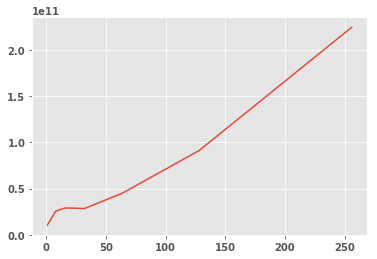

In [6]:
tot_cyc_data = select_metric_from_scaling(metric_data, 'PAPI_TOT_CYC')
# for kt in tot_cyc_data:
#     # tot_cyc_list = tot_cyc_data[kt].groupby(['thread'])['Inclusive'].sum()
#     tot_cyc_list = tot_cyc_data[kt]['Inclusive'].sum()
#     print tot_cyc_list
    
thread_list  = sorted(tot_cyc_data.keys())
print(thread_list)
tot_cyc_list = [tot_cyc_data[kt]['Inclusive'].sum() for kt in thread_list]

plt = matplotlib.pyplot.plot(thread_list, tot_cyc_list)

1


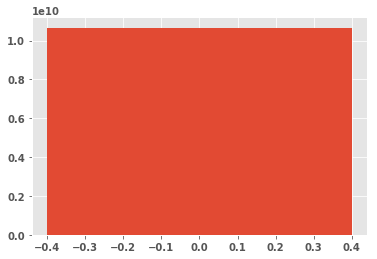

8


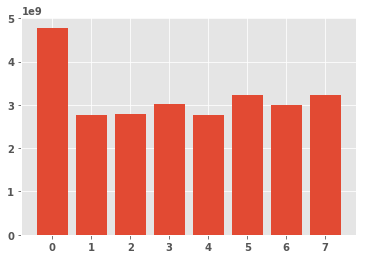

16


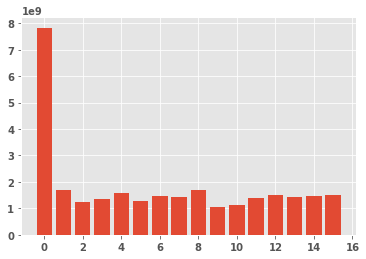

32


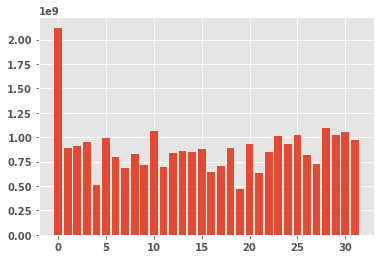

64


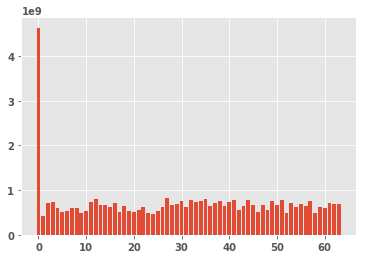

128


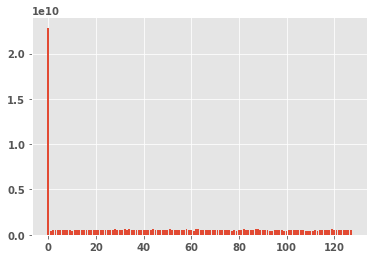

256


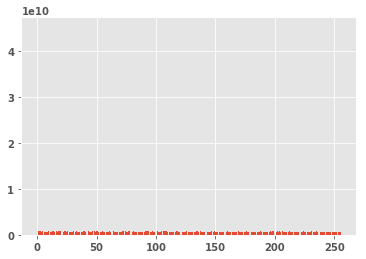

In [18]:
thread_cyc_data = get_thread_level_metric_scaling(tot_cyc_data)

plt_list=[]
for kt in thread_list:
    print kt
    data = list(thread_cyc_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.show()

In [ ]:
for kt in thread_list:
    cycles_var = scaling_plot_test(tot_cyc_data[kt],inclusive=True,sort=False,plot=True)

In [ ]:
l1_mr = select_metric_from_scaling(metric_data, 'DERIVED_L1_MISSRATE')
for kt in thread_list:
    cycles_var = scaling_plot(l1_mr[kt],inclusive=True,sort=False,plot=True)

In [ ]:
print "Thread 12"
thread_12 = l1_mr[32].xs(12, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
thread_12.head(20)

In [ ]:
print "Thread 0"
thread_0 = l1_mr[32].xs(0, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
thread_0.head(20)

In [ ]:
print "Thread 1"
thread_1 = l1_mr[32].xs(1, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
thread_1.head(20)

In [ ]:
res_stl = select_metric_from_scaling(metric_data, 'PAPI_RES_STL')
for kt in thread_list:
    cycles_var = scaling_plot(res_stl[kt],inclusive=True,sort=False,plot=True)

In [ ]:
l2_mr = select_metric_from_scaling(metric_data, 'DERIVED_L2_MISSRATE')
for kt in thread_list:
    cycles_var = scaling_plot(l2_mr[kt],inclusive=True,sort=False,plot=True)

In [ ]:
l3_mr = select_metric_from_scaling(metric_data, 'DERIVED_L3_MISSRATE')
for kt in thread_list:
    cycles_var = scaling_plot(l3_mr[kt],inclusive=True,sort=False,plot=True)

In [ ]:
print([tot_cyc_data[kt]['Inclusive'].max() for kt in thread_list])